In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm
from glob import glob
import random

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

# Set random seeds for reproducibility
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

In [2]:
# Data Loading and Exploration
base_dir = "kaggle_3m"
data_csv = os.path.join(base_dir, "data.csv")

# Load metadata
df = pd.read_csv(data_csv)
print(f"Dataset contains {len(df)} entries")

# Get a list of all patient folders
patient_folders = [f for f in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, f)) and f not in ['__pycache__']]
print(f"Found {len(patient_folders)} patient folders")

# Sample a patient folder to understand structure
if patient_folders:
    sample_patient = patient_folders[0]
    sample_files = os.listdir(os.path.join(base_dir, sample_patient))
    print(f"Sample patient folder {sample_patient} contains: {sample_files[:5]}...")

Dataset contains 110 entries
Found 110 patient folders
Sample patient folder TCGA_CS_4941_19960909 contains: ['TCGA_CS_4941_19960909_1.tif', 'TCGA_CS_4941_19960909_10.tif', 'TCGA_CS_4941_19960909_10_mask.tif', 'TCGA_CS_4941_19960909_11.tif', 'TCGA_CS_4941_19960909_11_mask.tif']...


In [3]:
# Data Preprocessing
def load_and_preprocess_data():
    images = []
    masks = []
    
    for patient_folder in tqdm(patient_folders):
        patient_path = os.path.join(base_dir, patient_folder)
        
        # Find all image files and their corresponding masks
        image_files = [f for f in glob(os.path.join(patient_path, "**/*"), recursive=True) 
                      if f.endswith(('.png', '.jpg', '.jpeg', '.tif')) and 'mask' not in f.lower()]
        
        for img_path in image_files:
            # Assuming mask file is in the same folder with a pattern like "[image_name]_mask.[ext]"
            base_name = os.path.splitext(img_path)[0]
            mask_path = f"{base_name}_mask{os.path.splitext(img_path)[1]}"
            
            if os.path.exists(mask_path):
                # Load and preprocess image
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                if img is not None:
                    img = cv2.resize(img, (256, 256))
                    img = img / 255.0  # Normalize to [0, 1]
                    
                    # Load and preprocess mask
                    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
                    if mask is not None:
                        mask = cv2.resize(mask, (256, 256))
                        mask = (mask > 0).astype(np.float32)  # Binary mask
                        
                        images.append(img)
                        masks.append(mask)
    
    return np.array(images), np.array(masks)

# Load data (commented out to avoid immediate execution)
# images, masks = load_and_preprocess_data()
# print(f"Loaded {len(images)} images and {len(masks)} masks")

In [4]:
# Define Dataset class
class BrainMRIDataset(Dataset):
    def __init__(self, images, masks, transform=None):
        self.images = images
        self.masks = masks
        self.transform = transform
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        image = self.images[idx]
        mask = self.masks[idx]
        
        # Add channel dimension
        image = np.expand_dims(image, axis=0)
        mask = np.expand_dims(mask, axis=0)
        
        # Convert to PyTorch tensors
        image = torch.from_numpy(image).float()
        mask = torch.from_numpy(mask).float()
        
        if self.transform:
            image = self.transform(image)
            
        return image, mask

# Split data into train, validation, and test sets
def train_val_test_split(images, masks, val_ratio=0.15, test_ratio=0.15):
    n = len(images)
    test_size = int(n * test_ratio)
    val_size = int(n * val_ratio)
    train_size = n - val_size - test_size
    
    indices = np.random.permutation(n)
    train_indices = indices[:train_size]
    val_indices = indices[train_size:train_size+val_size]
    test_indices = indices[train_size+val_size:]
    
    train_images, train_masks = images[train_indices], masks[train_indices]
    val_images, val_masks = images[val_indices], masks[val_indices] 
    test_images, test_masks = images[test_indices], masks[test_indices]
    
    return (train_images, train_masks), (val_images, val_masks), (test_images, test_masks)

In [5]:
# Define ResUNet Model Components
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        # Add skip connection if input and output channels differ
        self.shortcut = nn.Sequential()
        if in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1),
                nn.BatchNorm2d(out_channels)
            )
        
    def forward(self, x):
        residual = self.shortcut(x)
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += residual
        out = F.relu(out)
        return out

class UpConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UpConv, self).__init__()
        self.up = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)
        self.conv = ResidualBlock(in_channels, out_channels)
        
    def forward(self, x1, x2):
        x1 = self.up(x1)
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

class ResUNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1):
        super(ResUNet, self).__init__()
        
        # Encoder
        self.enc1 = ResidualBlock(in_channels, 64)
        self.pool1 = nn.MaxPool2d(2)
        self.enc2 = ResidualBlock(64, 128)
        self.pool2 = nn.MaxPool2d(2)
        self.enc3 = ResidualBlock(128, 256)
        self.pool3 = nn.MaxPool2d(2)
        self.enc4 = ResidualBlock(256, 512)
        self.pool4 = nn.MaxPool2d(2)
        
        # Bridge
        self.bridge = ResidualBlock(512, 1024)
        
        # Decoder
        self.dec4 = UpConv(1024, 512)
        self.dec3 = UpConv(512, 256)
        self.dec2 = UpConv(256, 128)
        self.dec1 = UpConv(128, 64)
        
        # Output
        self.final = nn.Sequential(
            nn.Conv2d(64, out_channels, kernel_size=1),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        # Encoder
        enc1 = self.enc1(x)
        enc2 = self.enc2(self.pool1(enc1))
        enc3 = self.enc3(self.pool2(enc2))
        enc4 = self.enc4(self.pool3(enc3))
        
        # Bridge
        bridge = self.bridge(self.pool4(enc4))
        
        # Decoder
        dec4 = self.dec4(bridge, enc4)
        dec3 = self.dec3(dec4, enc3)
        dec2 = self.dec2(dec3, enc2)
        dec1 = self.dec1(dec2, enc1)
        
        # Output
        return self.final(dec1)

In [6]:
# Define loss functions
def dice_loss(pred, target):
    smooth = 1.0
    
    pred_flat = pred.view(-1)
    target_flat = target.view(-1)
    
    intersection = (pred_flat * target_flat).sum()
    dice_score = (2. * intersection + smooth) / (pred_flat.sum() + target_flat.sum() + smooth)
    
    return 1 - dice_score

def combined_loss(pred, target, bce_weight=0.5):
    bce = F.binary_cross_entropy(pred, target)
    dice = dice_loss(pred, target)
    
    return bce_weight * bce + (1 - bce_weight) * dice

In [7]:
# Training function
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler=None, 
                num_epochs=100, patience=10, device='cuda'):
    model.to(device)
    best_val_loss = float('inf')
    patient_counter = 0
    best_model_path = 'best_resunet_model.pt'
    
    # Initialize history dict to store metrics
    history = {
        'train_loss': [],
        'val_loss': [],
        'train_dice': [],
        'val_dice': []
    }
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        train_dice = 0.0
        
        for images, masks in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} (Training)"):
            images = images.to(device)
            masks = masks.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, masks)
            
            # Calculate dice for tracking
            with torch.no_grad():
                dice = dice_loss(outputs, masks)
                train_dice += dice.item()
            
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
        
        # Calculate average metrics for the epoch
        avg_train_loss = train_loss / len(train_loader)
        avg_train_dice = train_dice / len(train_loader)
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        val_dice = 0.0
        
        with torch.no_grad():
            for images, masks in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} (Validation)"):
                images = images.to(device)
                masks = masks.to(device)
                
                outputs = model(images)
                loss = criterion(outputs, masks)
                
                val_loss += loss.item()
                val_dice += (dice_loss(outputs, masks)).item()
        
        avg_val_loss = val_loss / len(val_loader)
        avg_val_dice = val_dice / len(val_loader)
        
        # Update learning rate if scheduler exists
        if scheduler is not None:
            scheduler.step(avg_val_loss)
        
        # Save history
        history['train_loss'].append(avg_train_loss)
        history['val_loss'].append(avg_val_loss)
        history['train_dice'].append(avg_train_dice)
        history['val_dice'].append(avg_val_dice)
        
        # Print progress
        print(f"Epoch {epoch+1}/{num_epochs} - "
              f"Train Loss: {avg_train_loss:.4f}, Train Dice: {avg_train_dice:.4f}, "
              f"Val Loss: {avg_val_loss:.4f}, Val Dice: {avg_val_dice:.4f}")
        
        # Save best model and check for early stopping
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), best_model_path)
            print(f"Saved best model with validation loss: {best_val_loss:.4f}")
            patient_counter = 0
        else:
            patient_counter += 1
            print(f"EarlyStopping counter: {patient_counter} out of {patience}")
            if patient_counter >= patience:
                print("Early stopping triggered")
                break
    
    # Load best model
    model.load_state_dict(torch.load(best_model_path))
    
    return model, history

In [8]:
# Visualization function
def visualize_results(model, test_loader, num_samples=5, device='cuda'):
    model.eval()
    
    fig, axes = plt.subplots(num_samples, 3, figsize=(15, num_samples * 5))
    
    with torch.no_grad():
        for i, (images, masks) in enumerate(test_loader):
            if i >= num_samples:
                break
                
            images = images.to(device)
            masks = masks.to(device)
            
            outputs = model(images)
            
            # Move to CPU for visualization
            image = images[0, 0].cpu().numpy()
            mask = masks[0, 0].cpu().numpy()
            pred = outputs[0, 0].cpu().numpy() > 0.5  # Apply threshold
            
            # Plot results
            axes[i, 0].imshow(image, cmap='gray')
            axes[i, 0].set_title('Input Image')
            axes[i, 0].axis('off')
            
            axes[i, 1].imshow(mask, cmap='gray')
            axes[i, 1].set_title('Ground Truth')
            axes[i, 1].axis('off')
            
            axes[i, 2].imshow(pred, cmap='gray')
            axes[i, 2].set_title('Prediction')
            axes[i, 2].axis('off')
    
    plt.tight_layout()
    plt.savefig('resunet_results.png')
    plt.show()

# Function to calculate metrics on test set
def evaluate_model(model, test_loader, device='cuda'):
    model.eval()
    test_dice = 0.0
    
    with torch.no_grad():
        for images, masks in tqdm(test_loader, desc="Evaluating"):
            images = images.to(device)
            masks = masks.to(device)
            
            outputs = model(images)
            pred = (outputs > 0.5).float()  # Apply threshold
            
            # Calculate dice score
            dice = 1 - dice_loss(pred, masks)
            test_dice += dice.item()
    
    avg_test_dice = test_dice / len(test_loader)
    print(f"Test Dice Score: {avg_test_dice:.4f}")
    
    return avg_test_dice

In [9]:
# Main execution pipeline
def run_unet_pipeline():
    # Set device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    # Load and preprocess data
    print("Loading data...")
    images, masks = load_and_preprocess_data()
    
    # Split data
    (train_images, train_masks), (val_images, val_masks), (test_images, test_masks) = train_val_test_split(images, masks)
    
    print(f"Train: {len(train_images)}, Validation: {len(val_images)}, Test: {len(test_images)}")
    
    # Create datasets
    train_dataset = BrainMRIDataset(train_images, train_masks)
    val_dataset = BrainMRIDataset(val_images, val_masks)
    test_dataset = BrainMRIDataset(test_images, test_masks)
    
    # Create data loaders
    batch_size = 8
    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)
    test_loader = DataLoader(test_dataset, batch_size=1)
    
    # Initialize model, optimizer, and loss function
    model = ResUNet(in_channels=1, out_channels=1)
    optimizer = optim.Adam(model.parameters(), lr=1e-4)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5)
    
    # Define loss function (50% BCE + 50% Dice)
    criterion = lambda pred, target: combined_loss(pred, target, bce_weight=0.5)
    
    # Train model
    model, history = train_model(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        criterion=criterion,
        optimizer=optimizer,
        scheduler=scheduler,
        num_epochs=100,
        patience=10,
        device=device
    )
    
    # Plot training history
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train')
    plt.plot(history['val_loss'], label='Validation')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history['train_dice'], label='Train')
    plt.plot(history['val_dice'], label='Validation')
    plt.title('Dice Score')
    plt.xlabel('Epoch')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig('resunet_training_history.png')
    plt.show()
    
    # Evaluate on test set
    test_dice = evaluate_model(model, test_loader, device)
    
    # Visualize results
    visualize_results(model, test_loader, num_samples=5, device=device)
    
    return model, test_dice


Using device: cuda
Loading data...


100%|██████████| 110/110 [00:02<00:00, 44.19it/s]


Train: 2751, Validation: 589, Test: 589


Epoch 1/100 (Validation): 100%|██████████| 74/74 [00:04<00:00, 15.61it/s]


Epoch 1/100 - Train Loss: 0.5562, Train Dice: 0.9347, Val Loss: 0.5284, Val Dice: 0.8911
Saved best model with validation loss: 0.5284


Epoch 2/100 (Validation): 100%|██████████| 74/74 [00:04<00:00, 15.63it/s]


Epoch 2/100 - Train Loss: 0.4736, Train Dice: 0.8566, Val Loss: 0.4490, Val Dice: 0.8197
Saved best model with validation loss: 0.4490


Epoch 3/100 (Validation): 100%|██████████| 74/74 [00:04<00:00, 15.59it/s]


Epoch 3/100 - Train Loss: 0.3946, Train Dice: 0.7327, Val Loss: 0.3536, Val Dice: 0.6656
Saved best model with validation loss: 0.3536


Epoch 4/100 (Validation): 100%|██████████| 74/74 [00:04<00:00, 15.50it/s]


Epoch 4/100 - Train Loss: 0.3048, Train Dice: 0.5736, Val Loss: 0.3548, Val Dice: 0.6768
EarlyStopping counter: 1 out of 10


Epoch 5/100 (Validation): 100%|██████████| 74/74 [00:04<00:00, 15.60it/s]


Epoch 5/100 - Train Loss: 0.2491, Train Dice: 0.4682, Val Loss: 0.2288, Val Dice: 0.4346
Saved best model with validation loss: 0.2288


Epoch 6/100 (Validation): 100%|██████████| 74/74 [00:04<00:00, 15.51it/s]


Epoch 6/100 - Train Loss: 0.1935, Train Dice: 0.3626, Val Loss: 0.2257, Val Dice: 0.4252
Saved best model with validation loss: 0.2257


Epoch 7/100 (Validation): 100%|██████████| 74/74 [00:04<00:00, 15.58it/s]


Epoch 7/100 - Train Loss: 0.1683, Train Dice: 0.3137, Val Loss: 0.1953, Val Dice: 0.3699
Saved best model with validation loss: 0.1953


Epoch 8/100 (Validation): 100%|██████████| 74/74 [00:04<00:00, 15.61it/s]


Epoch 8/100 - Train Loss: 0.1541, Train Dice: 0.2865, Val Loss: 0.2496, Val Dice: 0.4670
EarlyStopping counter: 1 out of 10


Epoch 9/100 (Validation): 100%|██████████| 74/74 [00:04<00:00, 15.61it/s]


Epoch 9/100 - Train Loss: 0.1465, Train Dice: 0.2715, Val Loss: 0.1869, Val Dice: 0.3518
Saved best model with validation loss: 0.1869


Epoch 10/100 (Validation): 100%|██████████| 74/74 [00:04<00:00, 15.57it/s]


Epoch 10/100 - Train Loss: 0.1391, Train Dice: 0.2579, Val Loss: 0.1547, Val Dice: 0.2898
Saved best model with validation loss: 0.1547


Epoch 11/100 (Validation): 100%|██████████| 74/74 [00:04<00:00, 15.62it/s]


Epoch 11/100 - Train Loss: 0.1256, Train Dice: 0.2311, Val Loss: 0.1598, Val Dice: 0.2979
EarlyStopping counter: 1 out of 10


Epoch 12/100 (Validation): 100%|██████████| 74/74 [00:04<00:00, 15.55it/s]


Epoch 12/100 - Train Loss: 0.1083, Train Dice: 0.1995, Val Loss: 0.1359, Val Dice: 0.2546
Saved best model with validation loss: 0.1359


Epoch 13/100 (Validation): 100%|██████████| 74/74 [00:04<00:00, 15.61it/s]


Epoch 13/100 - Train Loss: 0.1000, Train Dice: 0.1840, Val Loss: 0.1290, Val Dice: 0.2404
Saved best model with validation loss: 0.1290


Epoch 14/100 (Validation): 100%|██████████| 74/74 [00:04<00:00, 15.50it/s]


Epoch 14/100 - Train Loss: 0.0995, Train Dice: 0.1821, Val Loss: 0.1420, Val Dice: 0.2658
EarlyStopping counter: 1 out of 10


Epoch 15/100 (Validation): 100%|██████████| 74/74 [00:04<00:00, 15.49it/s]


Epoch 15/100 - Train Loss: 0.0950, Train Dice: 0.1754, Val Loss: 0.1346, Val Dice: 0.2508
EarlyStopping counter: 2 out of 10


Epoch 16/100 (Validation): 100%|██████████| 74/74 [00:04<00:00, 15.55it/s]


Epoch 16/100 - Train Loss: 0.0913, Train Dice: 0.1685, Val Loss: 0.1298, Val Dice: 0.2422
EarlyStopping counter: 3 out of 10


Epoch 17/100 (Validation): 100%|██████████| 74/74 [00:04<00:00, 15.56it/s]


Epoch 17/100 - Train Loss: 0.0830, Train Dice: 0.1524, Val Loss: 0.1227, Val Dice: 0.2285
Saved best model with validation loss: 0.1227


Epoch 18/100 (Validation): 100%|██████████| 74/74 [00:04<00:00, 15.57it/s]


Epoch 18/100 - Train Loss: 0.1031, Train Dice: 0.1891, Val Loss: 0.2198, Val Dice: 0.4075
EarlyStopping counter: 1 out of 10


Epoch 19/100 (Validation): 100%|██████████| 74/74 [00:04<00:00, 15.55it/s]


Epoch 19/100 - Train Loss: 0.0920, Train Dice: 0.1685, Val Loss: 0.1133, Val Dice: 0.2101
Saved best model with validation loss: 0.1133


Epoch 20/100 (Validation): 100%|██████████| 74/74 [00:05<00:00, 14.52it/s]


Epoch 20/100 - Train Loss: 0.0755, Train Dice: 0.1382, Val Loss: 0.1219, Val Dice: 0.2272
EarlyStopping counter: 1 out of 10


Epoch 21/100 (Validation): 100%|██████████| 74/74 [00:05<00:00, 14.63it/s]


Epoch 21/100 - Train Loss: 0.0749, Train Dice: 0.1374, Val Loss: 0.1222, Val Dice: 0.2262
EarlyStopping counter: 2 out of 10


Epoch 22/100 (Validation): 100%|██████████| 74/74 [00:05<00:00, 14.72it/s]


Epoch 22/100 - Train Loss: 0.0758, Train Dice: 0.1389, Val Loss: 0.1286, Val Dice: 0.2390
EarlyStopping counter: 3 out of 10


Epoch 23/100 (Validation): 100%|██████████| 74/74 [00:05<00:00, 14.43it/s]


Epoch 23/100 - Train Loss: 0.0748, Train Dice: 0.1374, Val Loss: 0.1126, Val Dice: 0.2097
Saved best model with validation loss: 0.1126


Epoch 24/100 (Validation): 100%|██████████| 74/74 [00:05<00:00, 14.45it/s]


Epoch 24/100 - Train Loss: 0.0757, Train Dice: 0.1384, Val Loss: 0.1061, Val Dice: 0.1967
Saved best model with validation loss: 0.1061


Epoch 25/100 (Validation): 100%|██████████| 74/74 [00:04<00:00, 15.64it/s]


Epoch 25/100 - Train Loss: 0.0646, Train Dice: 0.1183, Val Loss: 0.1145, Val Dice: 0.2133
EarlyStopping counter: 1 out of 10


Epoch 26/100 (Validation): 100%|██████████| 74/74 [00:04<00:00, 15.54it/s]


Epoch 26/100 - Train Loss: 0.0767, Train Dice: 0.1393, Val Loss: 0.1022, Val Dice: 0.1900
Saved best model with validation loss: 0.1022


Epoch 27/100 (Validation): 100%|██████████| 74/74 [00:04<00:00, 15.62it/s]


Epoch 27/100 - Train Loss: 0.0627, Train Dice: 0.1143, Val Loss: 0.1087, Val Dice: 0.2011
EarlyStopping counter: 1 out of 10


Epoch 28/100 (Validation): 100%|██████████| 74/74 [00:04<00:00, 15.58it/s]


Epoch 28/100 - Train Loss: 0.0664, Train Dice: 0.1214, Val Loss: 0.1053, Val Dice: 0.1953
EarlyStopping counter: 2 out of 10


Epoch 29/100 (Validation): 100%|██████████| 74/74 [00:04<00:00, 15.46it/s]


Epoch 29/100 - Train Loss: 0.0601, Train Dice: 0.1098, Val Loss: 0.1023, Val Dice: 0.1893
EarlyStopping counter: 3 out of 10


Epoch 30/100 (Validation): 100%|██████████| 74/74 [00:04<00:00, 15.62it/s]


Epoch 30/100 - Train Loss: 0.0632, Train Dice: 0.1157, Val Loss: 0.1134, Val Dice: 0.2116
EarlyStopping counter: 4 out of 10


Epoch 31/100 (Validation): 100%|██████████| 74/74 [00:04<00:00, 15.59it/s]


Epoch 31/100 - Train Loss: 0.0594, Train Dice: 0.1086, Val Loss: 0.1313, Val Dice: 0.2457
EarlyStopping counter: 5 out of 10


Epoch 32/100 (Validation): 100%|██████████| 74/74 [00:04<00:00, 15.59it/s]


Epoch 32/100 - Train Loss: 0.0572, Train Dice: 0.1046, Val Loss: 0.1030, Val Dice: 0.1917
EarlyStopping counter: 6 out of 10


Epoch 33/100 (Validation): 100%|██████████| 74/74 [00:04<00:00, 15.53it/s]


Epoch 33/100 - Train Loss: 0.0480, Train Dice: 0.0878, Val Loss: 0.1011, Val Dice: 0.1873
Saved best model with validation loss: 0.1011


Epoch 34/100 (Validation): 100%|██████████| 74/74 [00:04<00:00, 15.34it/s]


Epoch 34/100 - Train Loss: 0.0445, Train Dice: 0.0812, Val Loss: 0.1018, Val Dice: 0.1891
EarlyStopping counter: 1 out of 10


Epoch 35/100 (Validation): 100%|██████████| 74/74 [00:04<00:00, 15.59it/s]


Epoch 35/100 - Train Loss: 0.0474, Train Dice: 0.0870, Val Loss: 0.0976, Val Dice: 0.1808
Saved best model with validation loss: 0.0976


Epoch 36/100 (Validation): 100%|██████████| 74/74 [00:04<00:00, 15.57it/s]


Epoch 36/100 - Train Loss: 0.0443, Train Dice: 0.0809, Val Loss: 0.1028, Val Dice: 0.1903
EarlyStopping counter: 1 out of 10


Epoch 37/100 (Validation): 100%|██████████| 74/74 [00:04<00:00, 15.56it/s]


Epoch 37/100 - Train Loss: 0.0439, Train Dice: 0.0803, Val Loss: 0.0990, Val Dice: 0.1830
EarlyStopping counter: 2 out of 10


Epoch 38/100 (Validation): 100%|██████████| 74/74 [00:04<00:00, 15.61it/s]


Epoch 38/100 - Train Loss: 0.0450, Train Dice: 0.0825, Val Loss: 0.1274, Val Dice: 0.2313
EarlyStopping counter: 3 out of 10


Epoch 39/100 (Validation): 100%|██████████| 74/74 [00:04<00:00, 15.59it/s]


Epoch 39/100 - Train Loss: 0.0444, Train Dice: 0.0812, Val Loss: 0.0973, Val Dice: 0.1796
Saved best model with validation loss: 0.0973


Epoch 40/100 (Validation): 100%|██████████| 74/74 [00:04<00:00, 15.59it/s]


Epoch 40/100 - Train Loss: 0.0444, Train Dice: 0.0818, Val Loss: 0.1014, Val Dice: 0.1869
EarlyStopping counter: 1 out of 10


Epoch 41/100 (Validation): 100%|██████████| 74/74 [00:04<00:00, 15.61it/s]


Epoch 41/100 - Train Loss: 0.0413, Train Dice: 0.0756, Val Loss: 0.0981, Val Dice: 0.1799
EarlyStopping counter: 2 out of 10


Epoch 42/100 (Validation): 100%|██████████| 74/74 [00:04<00:00, 15.55it/s]


Epoch 42/100 - Train Loss: 0.0395, Train Dice: 0.0721, Val Loss: 0.1026, Val Dice: 0.1888
EarlyStopping counter: 3 out of 10


Epoch 43/100 (Validation): 100%|██████████| 74/74 [00:04<00:00, 15.61it/s]


Epoch 43/100 - Train Loss: 0.0384, Train Dice: 0.0703, Val Loss: 0.0927, Val Dice: 0.1707
Saved best model with validation loss: 0.0927


Epoch 44/100 (Validation): 100%|██████████| 74/74 [00:04<00:00, 15.60it/s]


Epoch 44/100 - Train Loss: 0.0365, Train Dice: 0.0667, Val Loss: 0.0962, Val Dice: 0.1775
EarlyStopping counter: 1 out of 10


Epoch 45/100 (Validation): 100%|██████████| 74/74 [00:04<00:00, 15.63it/s]


Epoch 45/100 - Train Loss: 0.0411, Train Dice: 0.0756, Val Loss: 0.1095, Val Dice: 0.1995
EarlyStopping counter: 2 out of 10


Epoch 46/100 (Validation): 100%|██████████| 74/74 [00:04<00:00, 15.60it/s]


Epoch 46/100 - Train Loss: 0.0495, Train Dice: 0.0907, Val Loss: 0.1050, Val Dice: 0.1934
EarlyStopping counter: 3 out of 10


Epoch 47/100 (Validation): 100%|██████████| 74/74 [00:04<00:00, 15.53it/s]


Epoch 47/100 - Train Loss: 0.0362, Train Dice: 0.0660, Val Loss: 0.0965, Val Dice: 0.1780
EarlyStopping counter: 4 out of 10


Epoch 48/100 (Validation): 100%|██████████| 74/74 [00:04<00:00, 15.60it/s]


Epoch 48/100 - Train Loss: 0.0355, Train Dice: 0.0650, Val Loss: 0.0951, Val Dice: 0.1748
EarlyStopping counter: 5 out of 10


Epoch 49/100 (Validation): 100%|██████████| 74/74 [00:04<00:00, 15.58it/s]


Epoch 49/100 - Train Loss: 0.0379, Train Dice: 0.0695, Val Loss: 0.0995, Val Dice: 0.1822
EarlyStopping counter: 6 out of 10


Epoch 50/100 (Validation): 100%|██████████| 74/74 [00:04<00:00, 15.51it/s]


Epoch 50/100 - Train Loss: 0.0350, Train Dice: 0.0641, Val Loss: 0.0944, Val Dice: 0.1737
EarlyStopping counter: 7 out of 10


Epoch 51/100 (Validation): 100%|██████████| 74/74 [00:04<00:00, 15.45it/s]


Epoch 51/100 - Train Loss: 0.0339, Train Dice: 0.0622, Val Loss: 0.0937, Val Dice: 0.1722
EarlyStopping counter: 8 out of 10


Epoch 52/100 (Validation): 100%|██████████| 74/74 [00:04<00:00, 15.61it/s]


Epoch 52/100 - Train Loss: 0.0307, Train Dice: 0.0560, Val Loss: 0.1016, Val Dice: 0.1865
EarlyStopping counter: 9 out of 10


Epoch 53/100 (Validation): 100%|██████████| 74/74 [00:04<00:00, 15.61it/s]
C:\Users\prati\AppData\Local\Temp\ipykernel_23824\937279845.py:93: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimen

Epoch 53/100 - Train Loss: 0.0317, Train Dice: 0.0581, Val Loss: 0.0950, Val Dice: 0.1743
EarlyStopping counter: 10 out of 10
Early stopping triggered


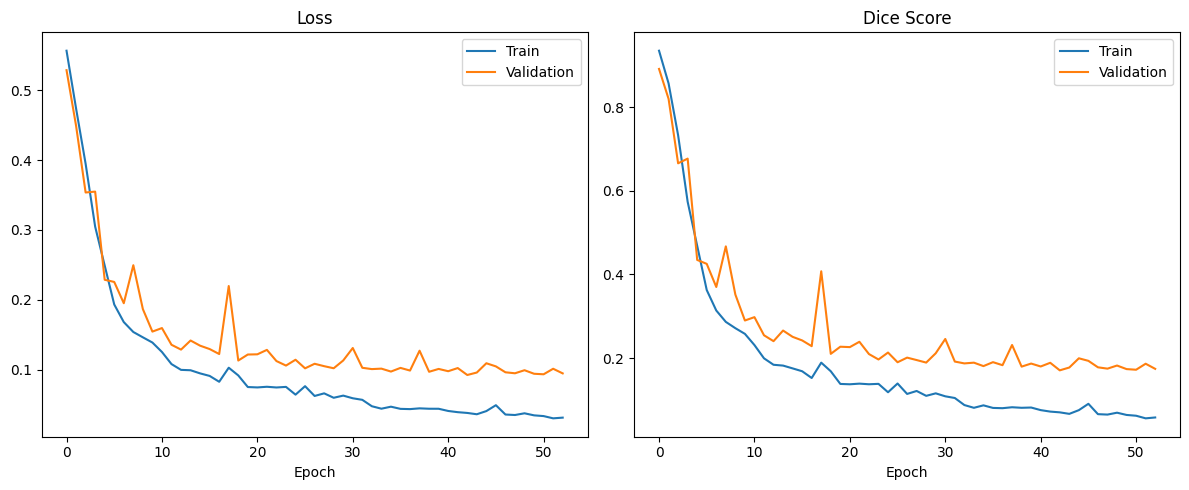

Evaluating: 100%|██████████| 589/589 [00:04<00:00, 143.57it/s]


Test Dice Score: 0.8946


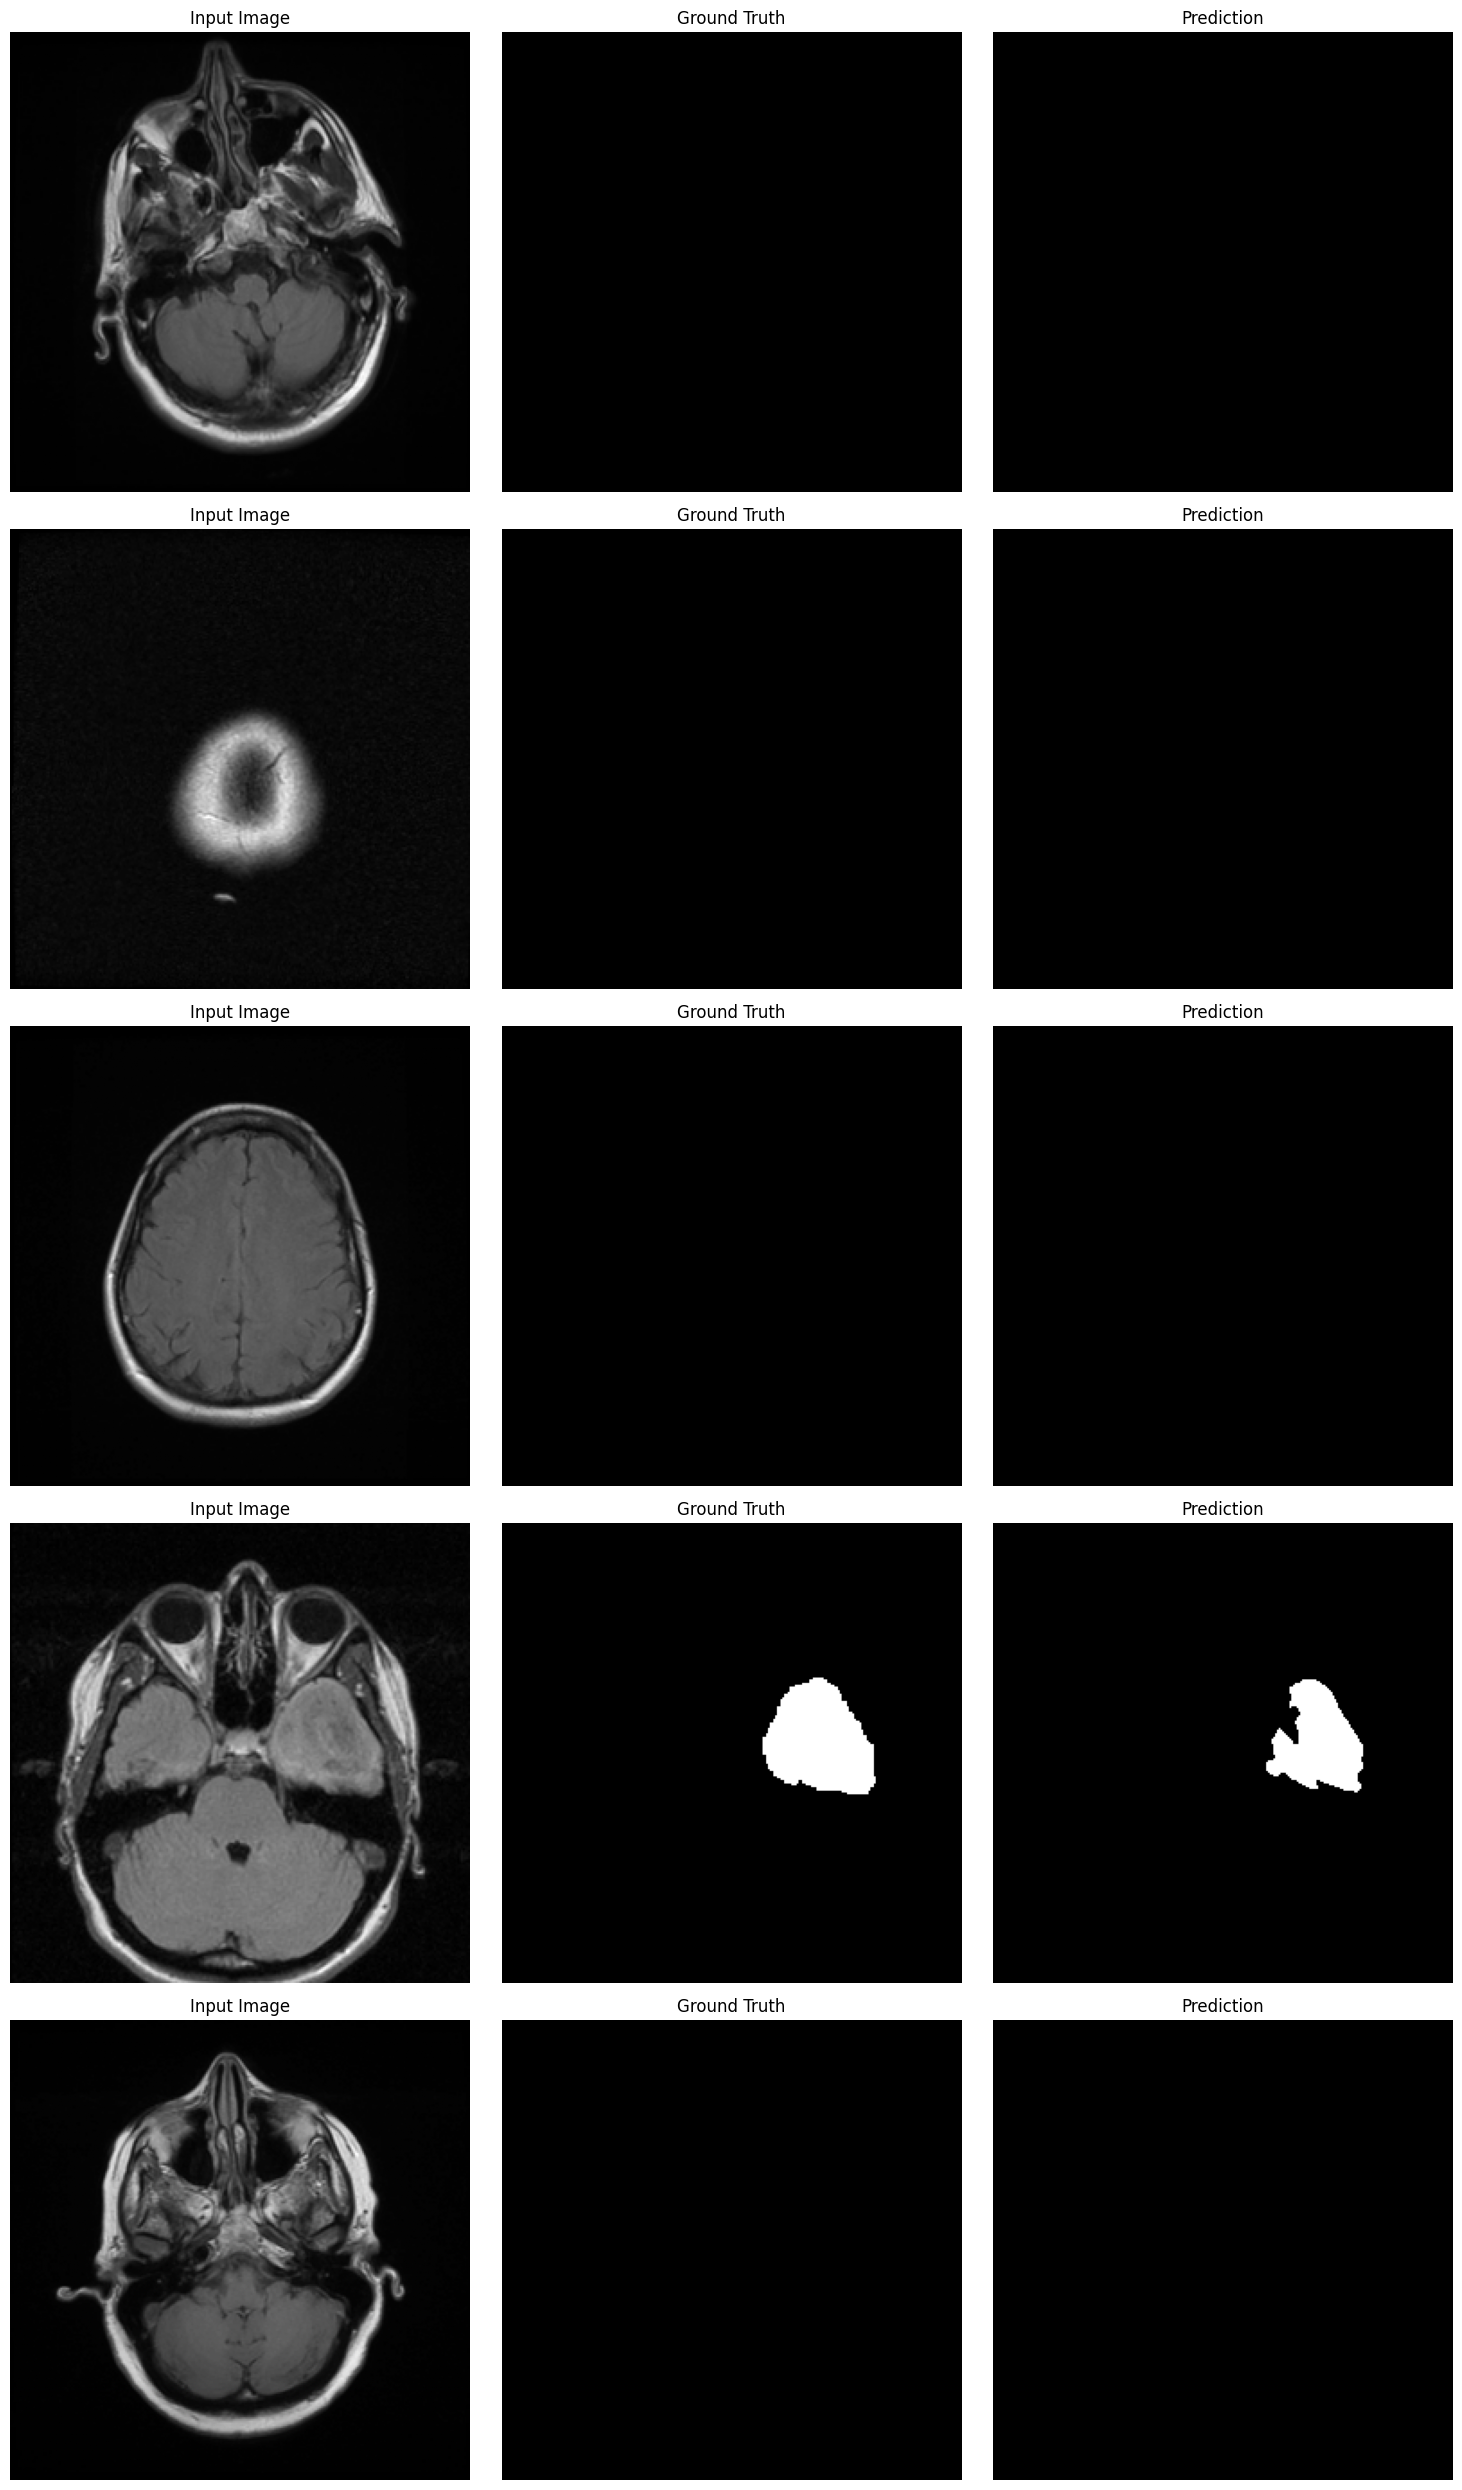

Final Test Dice Score: 0.8946


In [10]:
# Execute the full pipeline
if __name__ == "__main__":
    model, test_dice = run_unet_pipeline()
    print(f"Final Test Dice Score: {test_dice:.4f}")